## Лабораторная работа 2: Использование численных методов в задачах оптимизации
### 1. Поиск минимума функции:

\begin{align}
f(x)= \frac {1}{2} [ (x_ {1})^ {2} + \sum _ {i=1}^ {2} (x_ {i}-x_ {i+1})^ {2} + (x_ {3})^ {2} ]- x_ {1}
\end{align}


##### Представление применимости алгоритмов BFGS и L-BFGS к данной оптимизационной задаче

BFGS и L-BFGS применимы к дважды дифференцируемым выпуклым функциям.
Достаточно показать выполнение критерия Сильвестра. Матрица Гессе функции f(x):

\begin{equation}
H(f) =
\begin{bmatrix}
2 & -1 & 0 \\
-1 & 2 & -1 \\
0 & -1 & 2 \\
\end{bmatrix}
\end{equation}\
\begin{equation}
M_1 =
\left\lvert
\begin{matrix}
2
\end{matrix}
\right\rvert = 2 > 0
\end{equation}\
\begin{equation}
M_2 =
\left\lvert
\begin{matrix}
2 & -1 \\
-1 & 2
\end{matrix}
\right\rvert = 3 > 0
\end{equation}\
\begin{equation}
M_3 =
\left\lvert
\begin{matrix}
2 & -1 & 0 \\
-1 & 2 & -1 \\
0 & -1 & 2
\end{matrix}
\right\rvert = 4 > 0
\end{equation}

Все угловые миноры строго положительны - матрица Гессе положительно определена, а значит, f(x) является строго выпуклой (т. е. локальный минимум всегда глобальный).

##### Реализация алгоритмов BFGS и L-BFGS

In [1]:
import numpy as np
from time import time

# COMPUTATUON_TIME_MODE = False
# def get_time(f, *args, **kwargs):
#   start = time()
#   res = f(*args, **kwargs)
#   finish = time()
#   if COMPUTATUON_TIME_MODE:
#     return finish - start
#   else:
#     return res


In [2]:
def f(x: np.array):
  return (x[0]**2 + (x[0] - x[1])**2 + (x[1] - x[2])**2 + x[2]**2) / 2 - x[0]


def f_grad(x: np.array, f=None):
  grad = np.zeros(x.size)
  grad[0] = 2*x[0] - x[1] - 1
  grad[1] = 2*x[1] - x[0] - x[2]
  grad[2] = 2*x[2] - x[1]
  return grad


def f_grad_findiff(x: np.array, f, h=1e-6):
  grad = np.zeros(x.size)
  for i in range(x.size):
    incr = np.zeros(x.size)
    incr[i] = h
    grad[i] = (f(x + incr) - f(x - incr)) / (2*h)

  return grad




##### Приближение матрицы Гессе

In [3]:
def hesse(f, x, h=1e-6):
  n = x.shape[0]
  H = np.zeros((n, n), dtype=np.double)
  for j in range(n):
    for i in range(j, n):
      v = np.zeros((n,))
      v[j] = h
      g = np.zeros((n,))
      g[i] = h
      H[j, i] = (f(x + (g + v)) + f(x - (g + v)) - f(x + g - v) - f(x - g + v)) / 4 / h ** 2
  idx_lower = np.tril_indices(n, -1)
  H[idx_lower] = H.T[idx_lower]
  return H

hesse(f, np.array([1, -1, 1]))

array([[ 2.0001778 , -1.0000889 ,  0.        ],
       [-1.0000889 ,  2.00062189, -0.99986686],
       [ 0.        , -0.99986686,  2.0001778 ]])

In [4]:
def line_search_bisection(f, grad_func, x, p, c1=1e-4, c2=0.99, max_iter=1e6):
  alpha_max = 1e5
  alpha_min = 0
  t = 1
  while max_iter:
    max_iter -= 1
    x_new = x + t * p
    if f(x_new) > f(x) + c1 * t * grad_func(x, f).T @ p:
      alpha_max = t
      t = (alpha_max + alpha_min) / 2
    elif np.abs(grad_func(x_new, f).T @ p) > -c2 * grad_func(x, f).T @ p:
      alpha_min = t
      if (alpha_max < 1e5):
        t = (alpha_max + alpha_min) / 2
      else:
        t = 2 * alpha_min
    else:
      break;
  return t


def line_search(f, grad_func, x, p, c1=1e-4, c2=0.99, max_iter=1000):
  def zoom(min_, max_, iter=1e6):
    while iter:
      iter -= 1
      t = (max_ + min_) / 2
      x_new = x + t * p
      f_new = f(x_new)
      if f_new > f(x) + c1 * t * grad_func(x, f).T @ p or f_new >= f(x + min_ * p):
        max_ = t
      else:
        if np.abs(grad_func(x_new, f).T @ p) <= -c2 * grad_func(x, f).T @ p:
          return t
        if (max_ - min_) * grad_func(x + min_ * p, f).T @ p >= 0:
          max_ = min_
        min_ = t
    return t

  alpha_max=1e5
  alpha_min = 0
  t = alpha_min
  for _ in range(max_iter):
    t = (alpha_max + t) / 2
    x_new = x + t * p
    f_new = f(x_new)

    if f_new > f(x) + c1 * t * grad_func(x, f).T @ p or f_new >= f(x + alpha_min * p):
      return zoom(alpha_min, t, iter=max_iter)

    if np.abs(grad_func(x_new, f).T @ p) <= -c2 * grad_func(x, f).T @ p:
        return t
    if grad_func(x + alpha_min * p, f).T @ p >= 0:
      return zoom(t, alpha_max, iter=max_iter)
  return t


In [26]:
def BFGS(x0, f, grad_func, hesse_findiff=False, eps=1e-4, max_iter=1e6,):
  size = x0.size
  if hesse_findiff:
      H_inv = hesse(f, x0)
  else:
    H_inv = np.eye(size)


  grad = grad_func( x0, f)
  while np.linalg.norm(grad) > eps and max_iter > 0:
    p = -H_inv @ grad
    alpha = line_search(f, grad_func, x0, p)
    x0 = x0 + alpha * p
    grad_next = grad_func(x0, f)

    s = (alpha * p).reshape(len(p), 1)
    y = (grad_next - grad).reshape(len(p), 1)
    ro = 1 / (y.T @ s)
    H_inv = H_inv + ro**2 * (1/ro + y.T @ H_inv @ y) * s @ s.T - ro * (H_inv @ y @ s.T + s @ y.T @ H_inv)

    grad = grad_next
    max_iter -= 1
  return x0

In [14]:
x_start = np.ones(3)
BFGS(x_start, f, f_grad_findiff)

Optimization was done for 0.023489713668823242 sec.


array([0.74997875, 0.50000226, 0.2500254 ])

In [21]:
def LBFGS(x0, f, grad_func, m=3, hesse_findiff=False, eps=1e-4, max_iter=1e6):
  size = x0.size
  ys = [None] * m
  ss = [None] * m
  if hesse_findiff:
      H_inv = hesse(f, x0)
  else:
    H_inv = np.eye(size)

  grad = grad_func(x0, f)
  p = -grad
  alpha = line_search(f, grad_func, x0, p)
  ss[0] = (alpha * p).reshape(len(p), 1)
  x0 = x0 + alpha * p
  grad_next = grad_func(x0, f)
  ys[0] = (grad_next - grad).reshape(len(p), 1)

  k = 1
  while np.linalg.norm(grad) > eps and k < max_iter:
    p = -LBFGS2loop(grad, k, ss, ys)
    alpha = line_search(f, grad_func, x0, p)
    s = alpha * p
    x0 = x0 + s
    grad_next = grad_func(x0, f)
    s = s.reshape(len(p), 1)
    y = (grad_next - grad).reshape(len(p), 1)
    ss[k % m] = s
    ys[k % m] = y
    k += 1
    grad = grad_next
  return x0


def LBFGS2loop(grad, k, s, y):
  q = grad.reshape(len(grad), -1)
  m = len(s)
  alphas = [None] * m
  rhos = [None] * m
  for j in range(m):
    i = (k - j) % m
    if s[i] is None:
      continue
    rhos[i] = 1 / (s[i].T @ y[i])
    alphas[i] = rhos[i] * (s[i].T @ q)
    q = q - alphas[i] * y[i]

  start = k + 1
  while s[start % m] is None:
    start += 1
  start %= m
  gamma = (s[start].T @ y[start]) / (y[start ].T @ y[start])
  r = gamma * q
  for j in range(m):
    i = (j + k + 1) % m
    if s[i] is None:
      continue
    betha = rhos[i] * y[i].T @ r
    r = r + s[i] * (alphas[i] - betha)
  return r.flatten()


##### Сравнение алгоритмов BFGS и L-BFGS

In [23]:
!pip install memory_profiler

In [19]:
from memory_profiler import memory_usage

def profile(func, *args, **kwargs):
  mem_usage = max(memory_usage(
    (func, args, kwargs)
    ))
  comptime = time()
  func(*args, **kwargs)
  comptime -= time()
  comptime *= -1
  return mem_usage, comptime

profile(hesse, f, np.array([1, 20, 0]))

(202.4140625, 0.0004086494445800781)

Метод оптимизации:

*   Первый код реализует метод BFGS (Broyden-Fletcher-Goldfarb-Shanno)
*   Второй код реализует метод L-BFGS (Limited-memory BFGS) для оптимизации с ограниченной памятью, используя предыдущие итерации для аппроксимации гессиана.

Инициализация гессиана:

*   В первом коде инициализация гессиана происходит через функцию hesse(x0), которая возвращает началь
*   Во втором коде начальное приближение гессиана вычисляется с использованием предыдущих шагов (s и y) и параметров рассчитываемых коэффициентов (alphas и rhos).

Способ выбора шага:

*   Оба кода используют метод линейного поиска для выбора подходящего шага.

Ограничение по памяти:

*   Первый код не учитывает ограничение памяти и использует полную аппроксимацию обратного гессиана.
*   Второй код специально реализован для работы с ограниченной памятью, что делает его более эффективным при оптимизации функций с большим числом параметров.



In [65]:
fs = [BFGS, LBFGS]
hesse_findiffs = [True, False]
x0s = [
    np.array([0.76, 0.49, 0.24]),
    np.array([1.5, 1, -0.5]),
    np.array([100000, 0, 0]),
    np.array([100000, -100000, 2000])
]
grads = [f_grad, f_grad_findiff]

from itertools import product
import pandas as pd
res = pd.DataFrame(columns=['Function', 'HessInitViaFinDiff', 'InitGuess', 'Grad', 'Memory, MiB', 'Comptime, s'])
for i, (func, hes, x0, grad) in enumerate(product(fs, hesse_findiffs, x0s, grads)):
  m, t = profile(
      func,
      x0=x0, f=f, grad_func=grad,
      hesse_findiff=hes
  )
  res.loc[i] = (func.__name__, hes, x0, grad.__name__, m, t)



<ipython-input-26-a45fba54308f>:18: RuntimeWarning: divide by zero encountered in divide
  ro = 1 / (y.T @ s)
<ipython-input-26-a45fba54308f>:19: RuntimeWarning: invalid value encountered in multiply
  H_inv = H_inv + ro**2 * (1/ro + y.T @ H_inv @ y) * s @ s.T - ro * (H_inv @ y @ s.T + s @ y.T @ H_inv)
<ipython-input-26-a45fba54308f>:18: RuntimeWarning: divide by zero encountered in divide
  ro = 1 / (y.T @ s)
<ipython-input-26-a45fba54308f>:19: RuntimeWarning: invalid value encountered in multiply
  H_inv = H_inv + ro**2 * (1/ro + y.T @ H_inv @ y) * s @ s.T - ro * (H_inv @ y @ s.T + s @ y.T @ H_inv)
<ipython-input-26-a45fba54308f>:18: RuntimeWarning: divide by zero encountered in divide
  ro = 1 / (y.T @ s)
<ipython-input-26-a45fba54308f>:19: RuntimeWarning: invalid value encountered in multiply
  H_inv = H_inv + ro**2 * (1/ro + y.T @ H_inv @ y) * s @ s.T - ro * (H_inv @ y @ s.T + s @ y.T @ H_inv)
<ipython-input-26-a45fba54308f>:18: RuntimeWarning: divide by zero encountered in divide

In [66]:
res

,Function,HessInitViaFinDiff,InitGuess,Grad,"Memory, MiB","Comptime, s"
0,BFGS,True,"[0.76, 0.49, 0.24]",f_grad,329.453125,0.004105
1,BFGS,True,"[0.76, 0.49, 0.24]",f_grad_findiff,329.480469,0.006109
2,BFGS,True,"[1.5, 1.0, -0.5]",f_grad,329.496094,0.004345
3,BFGS,True,"[1.5, 1.0, -0.5]",f_grad_findiff,329.496094,0.007878
4,BFGS,True,"[100000, 0, 0]",f_grad,329.496094,0.052376
5,BFGS,True,"[100000, 0, 0]",f_grad_findiff,329.593750,0.134087
6,BFGS,True,"[100000, -100000, 2000]",f_grad,329.593750,0.060618
7,BFGS,True,"[100000, -100000, 2000]",f_grad_findiff,329.593750,0.142450
8,BFGS,False,"[0.76, 0.49, 0.24]",f_grad,329.593750,0.003729
9,BFGS,False,"[0.76, 0.49, 0.24]",f_grad_findiff,329.593750,0.009080


In [68]:
res.groupby('Function')['Memory, MiB'].aggregate('mean')

#Как можно заметить, потребление памяти для такой простой функции практически не отличается

Function
BFGS     329.559570
LBFGS    329.594727
Name: Memory, MiB, dtype: float64

Оценим время вычисления

Text(0.5, 1.0, 'finite difference gradient')

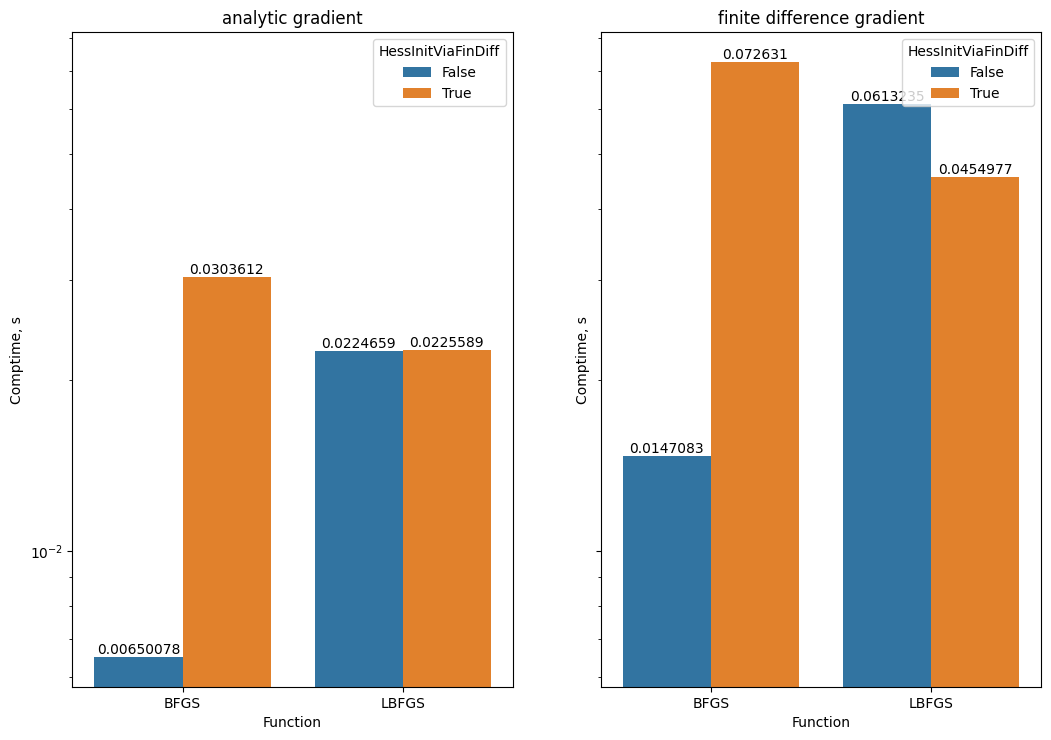

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, sharey=True, )
fig.set_size_inches(12.5, 8.5)
plt.yscale('log')
sns.barplot(res[res.Grad == 'f_grad'], x='Function', y='Comptime, s', hue='HessInitViaFinDiff', ax=axes[0], errorbar=None)
sns.barplot(res[res.Grad != 'f_grad'], x='Function', y='Comptime, s', hue='HessInitViaFinDiff', ax=axes[1], errorbar=None)

for container in axes[0].containers:
    axes[0].bar_label(container)
for container in axes[1].containers:
    axes[1].bar_label(container)

axes[0].set_title('analytic gradient')
axes[1].set_title('finite difference gradient')


Как следует из графиков, метод инициализации матрицы Гессе не играет особой роли в случае алгоритма LBFGS (разница не более чем в 1,5 раза)
тогда как для BFGS эти значения являются куда более радикальными (ускорение в примерно 5 раз в случае использования не единичного приближения)
При прочих равных, наилучшим методом с точки зрения скорости показал себя BFGS с использованием единичного приближения гессиана и аналитическим заданием градиента. Медленнее всего работает BFGS с градиентом на конечных разностях и градиентным заданием матрицы Гессе

### 2. Практическое применение: использование метода оптимизации L-BFGS для решения задачи логистической регрессии

##### Представление набора данных

In [73]:
#Information about dataset: https://www.kaggle.com/datasets/nareshbhat/wine-quality-binary-classification
!pip install ucimlrepo

In [101]:
from ucimlrepo import fetch_ucirepo

wine_quality = fetch_ucirepo(id=186)

n = 50
idx = np.random.random_sample
X = wine_quality.data.features.to_numpy()[:n, :]
y = (wine_quality.data.targets.to_numpy() >= 6).astype('int')[:n, :]

print(*[f'{k}: {v}' for k, v in wine_quality.metadata.items()], sep='\n')
print(wine_quality.variables)


uci_id: 186
name: Wine Quality
repository_url: https://archive.ics.uci.edu/dataset/186/wine+quality
data_url: https://archive.ics.uci.edu/static/public/186/data.csv
abstract: Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).
area: Business
tasks: ['Classification', 'Regression']
characteristics: ['Multivariate']
num_instances: 4898
num_features: 11
feature_types: ['Real']
demographics: []
target_col: ['quality']
index_col: None
has_missing_values: no
missing_values_symbol: None
year_of_dataset_creation: 2009
last_updated: Thu Aug 10 2023
dataset_doi: 10.24432/C56S3T
creators: ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis']
intro_paper: {'title': 'Modeling wine preferences by data mining from physicochemical properties', 'authors': 'P. Cortez, A. Cerdeira, Fernando Almeida, Telm

In [102]:
np.unique(y, return_counts=1)

(array([0, 1]), array([14, 36]))

##### Реализация логистической регрессии

In [103]:
def sigmoid(x):
  return 1. / (1. + np.exp(-x))

def cross_enthropy(y, ypred):
  N = len(y)
  eps = 1e-9
  res = - np.sum(y * np.log(ypred + eps)) - np.sum((1 - y) * np.log(1 - ypred + eps))
  return res

class LogReg:
  """
  Реализовано без задания аналитических градиентов -- так сказать, задание на свободное время))))
  """
  def __init__(self, penalty='l2', method='lbfgs', m=4, hesse_findiff=False, eps=1e-4, max_iter=1e6):
    self.method = method
    self.m = m
    self.hesse_findiff = hesse_findiff
    self.eps = eps
    self.max_iter = max_iter
    self.w = None
    self.if_fitted = False
    self.loss = cross_enthropy
    if penalty == 'l2':
      self.penalty = lambda w: np.sum(np.square(w))
    elif penalty == 'l1':
      self.penalty = lambda w: np.sum(np.abs(w))
    else:
      self.penalty = lambda w: 0

  def fit(self, X, y):
    def loss_func(w):
      preds = sigmoid(X @ w)
      return cross_enthropy(y, preds) + self.penalty(w)

    X = np.hstack([X, np.ones((X.shape[0], 1))]).astype(np.double)
    w = np.zeros(X.shape[1])

    if self.method == 'lbfgs':
      self.w = LBFGS(w, loss_func, f_grad_findiff, self.m, self.hesse_findiff, self.eps, self.max_iter)
    elif self.method == 'bfgs':
      self.w = BFGS(w, loss_func, f_grad_findiff, self.hesse_findiff, self.eps, self.max_iter)
    else:
      raise Exception('This method hasn\'t been implemented yet!')

    self.is_fitted = True
    return self

  def predict_proba(self, X):
    if not self.is_fitted:
      raise Exception('Model hasn\'t been fitted yet!')
    X = np.hstack([X, np.ones((X.shape[0], 1))])
    tmp = X @ self.w.reshape(len(self.w), -1)
    return sigmoid(tmp)

  def predict(self, X):
    return (self.predict_proba(X) > 0.5).astype('int')




##### Сравнение характеристики работы алгоритмов

In [110]:
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
xtr, xte, ytr, yte = train_test_split(X, y, random_state=42)

scaler = StandardScaler()
xtr = scaler.fit_transform(xtr)
xte = scaler.transform(xte)
imputer = SimpleImputer(fill_value=0)
xtr = imputer.fit_transform(xtr)
xte = imputer.transform(xte)


In [117]:
lr_fd = LogReg(penalty='l2', hesse_findiff=True)
lr_ = LogReg(penalty='l2', hesse_findiff=False)

t0 = time()
lr_fd.fit(xtr, ytr)
t1 = time()
print('Logisctic regression with finite differences Hessian computation time: ', t1 - t0)

t0 = time()
lr_.fit(xtr, ytr)
t1 = time()
print('Logisctic regression with identity matrix Hessian computation time: ', t1 - t0)

<ipython-input-21-4d20e219bd5e>:43: RuntimeWarning: divide by zero encountered in divide
  rhos[i] = 1 / (s[i].T @ y[i])
<ipython-input-21-4d20e219bd5e>:45: RuntimeWarning: invalid value encountered in multiply
  q = q - alphas[i] * y[i]
<ipython-input-21-4d20e219bd5e>:57: RuntimeWarning: invalid value encountered in multiply
  betha = rhos[i] * y[i].T @ r


Logisctic regression with finite differences Hessian computation time:  9.262907266616821
Logisctic regression with identity matrix Hessian computation time:  8.818696737289429


In [ ]:
print('MSE with finite differences Hessian: ', mean_squared_error(yte, lr_fd.predict_proba(xte)))
print('MSE with identity matrix Hessian: ', mean_squared_error(yte, lr_.predict_proba(xte)))

Всё поломалось в последний момент...
